# Graphing Helpers

Helper functions which graph various different streaming parameters 

In [10]:
%run LogFileProcessing.ipynb

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.lines import Line2D

## Quality Level vs Time

In [2]:
# Helper function to get x and y data for graphing
def getQualityData(parentDir):
    (adaptHeaders, adaptData) = readAdaptationLog(parentDir)
    
    # Pull out the two columns we care about as np arrays
    npAdaptData = np.array(adaptData)
    adaptSegments = npAdaptData[:,0]
    adaptQuality = npAdaptData[:,1]
    
    return (adaptSegments, adaptQuality)


def setIntegerYTickInterval(ax):
    # https://stackoverflow.com/questions/27496737/how-to-force-matplotlib-to-display-only-whole-numbers-on-the-y-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


# Helper function to get x and y data when graphing quality comparison plots
def getQualityComparisonData(dir1, dir2):
    segments1, quality1 = getQualityData(dir1)
    segments2, quality2 = getQualityData(dir2)
    
    # If one simulation got further, trim it back to match the other
    count1 = len(segments1)
    count2 = len(segments2)
    count = min(count1, count2)
    segments = segments1
    if (count1 != count2):
        count = min(count1, count2)
        segments = segments[:count]
        quality1 = quality1[:count]
        quality2 = quality2[:count]
    
    return (segments, quality1, quality2)

In [5]:
'''Graphs segment qualities over time

parentDir is the directory containing the log files for the simulation run in question.
'''
def graphAdaptationLevel(parentDir):
    segments, quality = getQualityData(parentDir)    
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)

    plt.xlabel("Video Segment")
    plt.ylabel("Quality Level")
    
    # Set the tick distribution for quality axis
    setIntegerYTickInterval(ax)

    # Set the tick distribution for x axis to every 10th segment
    maxSegment = segments[-1]
    xTickMax = (maxSegment/10) * 10 + 10
    plt.xticks(np.arange(0, xTickMax, 10))

    ax.plot(segments, quality, "o")


''' Graph the adaptation levels for two simulations on one figure
'''
def compareAdaptationLevelsOverlay(dir1, dir2, label1, label2):
    segments, quality1, quality2 = getQualityComparisonData(dir1, dir2)
    
    # Plot both qualities along the same axis   
    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(111)
    
    setIntegerYTickInterval(ax)
    
    ax.plot(segments, quality1, 'bx', label=label1)
    ax.plot(segments, quality2, 'g+', label=label2)

    plt.xlabel("Video Segment")
    plt.ylabel("Quality Level")
    
    plt.legend()
    plt.show()


''' Graph the adaptation levels for the QUIC and TCP simulations side-by-side
'''
def compareAdaptationLevelsSeparate(dir1, dir2, label1, label2):
    segments, quality1, quality2 = getQualityComparisonData(dir1, dir2)
    
    # Plot the qualities in separate figures   
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(15, 3))

    ax1.set_title(label1)
    ax2.set_title(label2)
    
    # Turn on the TCP plot's tick labels manually. They've been turned of by
    # sharing the axis between subplots.
    ax2.yaxis.set_tick_params(labelleft=True)
    
    # Enforce integer values for y axis ticks
    setIntegerYTickInterval(ax1)
    setIntegerYTickInterval(ax2)
    
    ax1.plot(segments, quality1, 'bo', label=label1)
    ax2.plot(segments, quality2, 'go', label=label2)

    ax1.set_xlabel("Video Segment")
    ax2.set_xlabel("Video Segment")
    ax1.set_ylabel("Quality Level")
    ax2.set_ylabel("Quality Level")
    
    plt.show()

Single quality level graph for QUIC data:
Side-by-side comparison


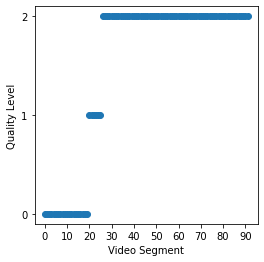

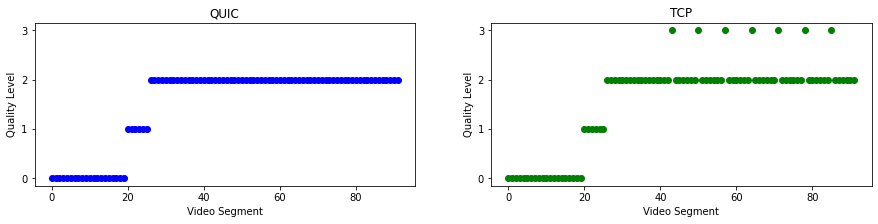

Overlayed comparison


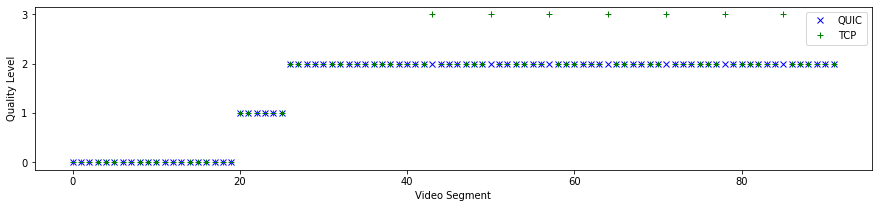

In [13]:
# Demo of how we can use the above functions to graph quality data

print ("Single quality level graph for QUIC data:")
graphAdaptationLevel(sampleQuicDir)

print ("Side-by-side comparison")
compareAdaptationLevelsSeparate(sampleQuicDir, sampleTcpDir, 'QUIC', 'TCP')

print ("Overlayed comparison")
compareAdaptationLevelsOverlay(sampleQuicDir, sampleTcpDir, 'QUIC', 'TCP')

## Buffer Level vs Time

In [14]:
def getBufferData(parentDir):
    # Ignore headers
    (_, bufferData) = readBufferLog(parentDir) 

    # Split out the columns
    npBufferData = np.array(bufferData)
    timestamps = npBufferData[:,0]
    levels = npBufferData[:,1]

    return (timestamps, levels)


def getBufferComparisonData(dir1, dir2):
    ts1, levels1 = getBufferData(dir1)
    ts2, levels2 = getBufferData(dir2)
    
    # Remove the timestamps from the longer run that go past where the other stopped.
    endTs1 = ts1[-1]
    endTs2 = ts2[-1]
    
    if abs(endTs1 - endTs2) > 1:   
        if endTs1 < endTs2:
            # Trim ts2 and levels2
            endIndex = np.argmax(ts2 > endTs1)
            ts2 = ts2[:endIndex]
            levels2 = levels2[:endIndex]
        else:
            # Trim ts1 and levels1
            endIndex = np.argmax(ts1 > endTs2)
            ts1 = ts1[:endIndex]
            levels1 = levels1[:endIndex]
    
    return (ts1, ts2, levels1, levels2)

In [20]:
# Graph buffer level of a single simulation over time
def graphBufferLevel(parentDir):
    times, levels = getBufferData(parentDir)
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times, levels)
    
    plt.show()

QUIC buffer level graph demo


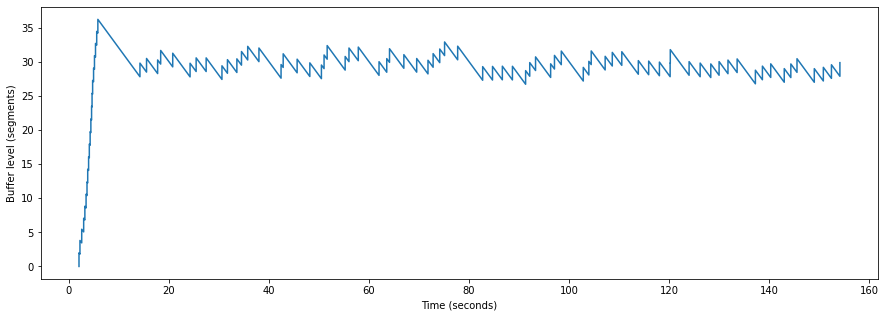

TCP buffer level graph demo


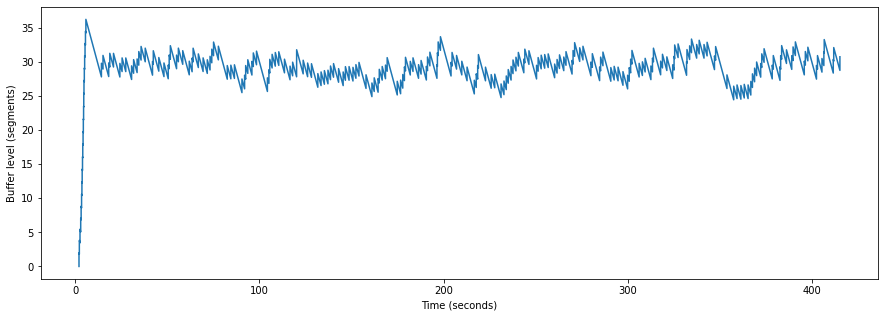

In [21]:
print ("QUIC buffer level graph demo")
graphBufferLevel(sampleQuicDir)

print ("TCP buffer level graph demo")
graphBufferLevel(sampleTcpDir)

In [22]:
# Graph buffer levels of two simulations overlayed on a single graph
def graphBufferLevelComparison(dir1, dir2, label1, label2):
    buffData = getBufferComparisonData(dir1, dir2)
    times1, times2, levels1, levels2 = buffData
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times1, levels1, ':', label=label1)
    ax.plot(times2, levels2, ':', label=label2)
    
    plt.legend()
    plt.show()

Buffer level comparison for normal rate


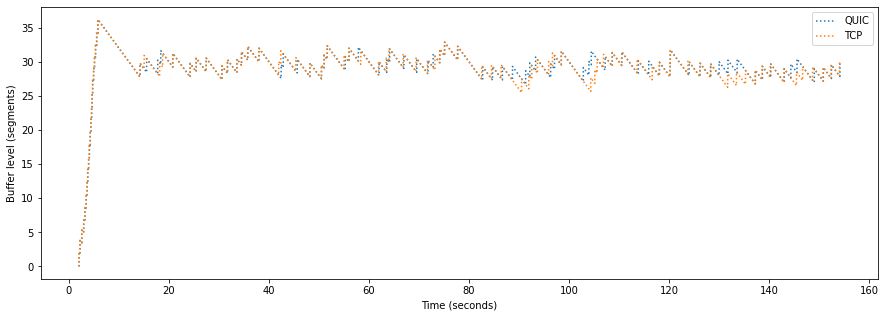

Buffer level comparison for slow rate


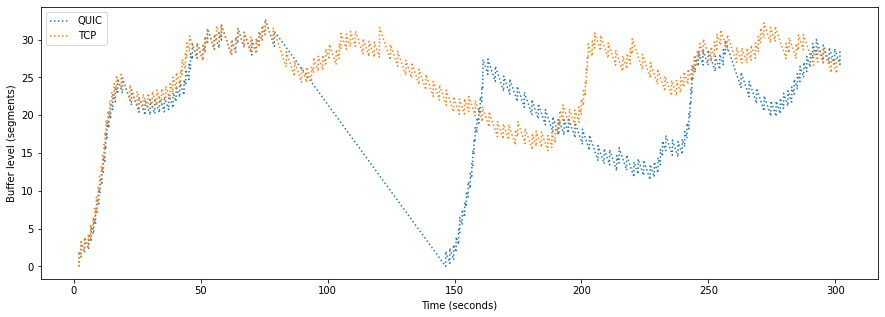

In [26]:
print ("Buffer level comparison for normal rate")
graphBufferLevelComparison(sampleQuicDir, sampleTcpDir, 'QUIC', 'TCP')

print ("Buffer level comparison for slow rate")
graphBufferLevelComparison(sampleQuicDirSlow, sampleTcpDirSlow, 'QUIC', 'TCP')

In [27]:
# Graph the buffer level over time, with markers showing buffer underflow 
# detection and recovery events
def graphBufferWithUnderflow(parentDir):
    times, levels = getBufferData(parentDir)
    underflowTimes = getUnderflowTimes(parentDir)
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times, levels, label="Buffer Level")
    
    # Add underflow lines to legend
    handles, labels = ax.get_legend_handles_labels()
    redLine = Line2D([0], [0], label='Underflow Detected', color='r')
    greenLine = Line2D([0], [0], label="Underflow Resolved", color ='g')    
    handles.extend([redLine, greenLine])
    
    # Mark underflows with vertical lines
    for (start, end) in underflowTimes:        
        plt.axvline(x=start, color="r")
        plt.axvline(x=end, color="g")

    plt.legend(handles=handles)
    plt.show()

Buffer level over time with underflow annotations
Malformed buffer underflow log. Likely that QUIC failed near time 330.524


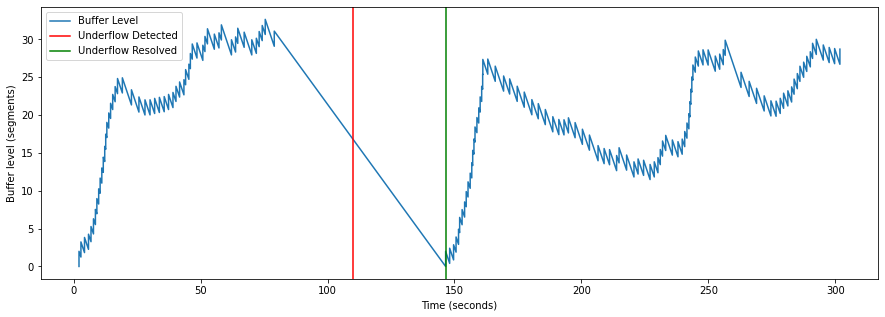

In [36]:
print ("Buffer level over time with underflow annotations")
graphBufferWithUnderflow(sampleQuicDirSlow)

## Simulation Timeline Graphing

Allows us to look at the buffer level, quality level, and throughput data for a simulation all along one timeline

In [25]:
def getUnderflowTimes(parentDir):
    (_, intervals) = readUnderflowLog(parentDir)
    return intervals


def getPlaybackData(parentDir):
    _, playbackRows = readPlaybackLog(parentDir)

    npData = np.array(playbackRows)
    segments = npData[:,0]
    playbackTimes = npData[:,1]
    qualityLevels = npData[:,2]
    
    return (segments, playbackTimes, qualityLevels)


def getDownloadData(parentDir):
    _, downloadRows = readDownloadLog(parentDir)
    
    npData = np.array(downloadRows)
    segments = npData[:,0]
    startTimes = npData[:,1]
    endTimes = npData[:,2]
    sizes = npData[:,3]
    
    return (startTimes, endTimes, sizes)

In [30]:
def graphFullTimeline(parentDir):
    bufferTimes, bufferLevels = getBufferData(parentDir)
    underflowTimes = getUnderflowTimes(parentDir)
    segments, playbackTimes, quality = getPlaybackData(parentDir)
    startTimes, endTimes, segmentSizes = getDownloadData(parentDir)
    downloadTimes, downloadSizes = readThroughputLog(parentDir)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex='col', figsize=(15, 12))

    # Buffer level plot (ax1)
    ax1.set_title("Buffer Level")   
    ax1.set_ylabel("Buffer level (segments)")
    
    ax1.plot(bufferTimes, bufferLevels, label="Buffer Level")
    
    # Add underflow lines to legend
    handles, labels = ax1.get_legend_handles_labels()
    redLine = Line2D([0], [0], label='Underflow Detected', color='r')
    greenLine = Line2D([0], [0], label="Underflow Resolved", color ='g')    
    handles.extend([redLine, greenLine])
    
    # Mark underflows with vertical lines
    for (start, end) in underflowTimes:        
        ax1.axvline(x=start, color="r")
        ax1.axvline(x=end, color="g")

    ax1.legend()

    # Playback quality plot (ax2)
    ax2.set_title("Playback Quality Levels")        
    ax2.set_ylabel("Playback quality level")
    setIntegerYTickInterval(ax2)
    
    ax2.plot(playbackTimes, quality, "o")
        
    # Download size plot (ax3)
    ax3.set_title("Segment Downloads")
    ax3.set_ylabel("Segment Download Size (bytes)")
    
    tickOffset = max(segmentSizes) / 80.0
    for segment in range (len(segments)):
        size = segmentSizes[segment]
        start = startTimes[segment]
        end = endTimes[segment]
        
        ax3.hlines(y=size, xmin=start, xmax=end, linewidth=1)
        ax3.vlines(x=start, ymin=size-tickOffset, ymax=size+tickOffset, linewidth=1)
        ax3.vlines(x=end, ymin=size-tickOffset, ymax=size+tickOffset, linewidth=1)
    
    # Throughput plot (ax4)
    ax4.set_title("Throughput (data received by client)")
    ax4.set_ylabel("Datagram Size (Bytes)")
    
    ax4.scatter(downloadTimes, downloadSizes, s=1)
    
    # Average Throughput plot (ax5)
    ax5.set_title("Data received each second")
    ax5.set_xlabel("Time (seconds)")    
    ax5.set_ylabel("Data Received (bytes)")    
    
    # Build up a bucket for each second
    maxWholeSecond = int(np.floor(downloadTimes[-1]))
    avgThroughputBars = np.zeros(maxWholeSecond + 1)
    for (time, size) in zip(downloadTimes, downloadSizes):
        bucket = int(np.floor(time))
        avgThroughputBars[bucket] += size

    ax5.bar(np.arange(len(avgThroughputBars)), avgThroughputBars)
        
    plt.show()

Full timeline for QUIC 500Kbps
Malformed buffer underflow log. Likely that QUIC failed near time 330.524


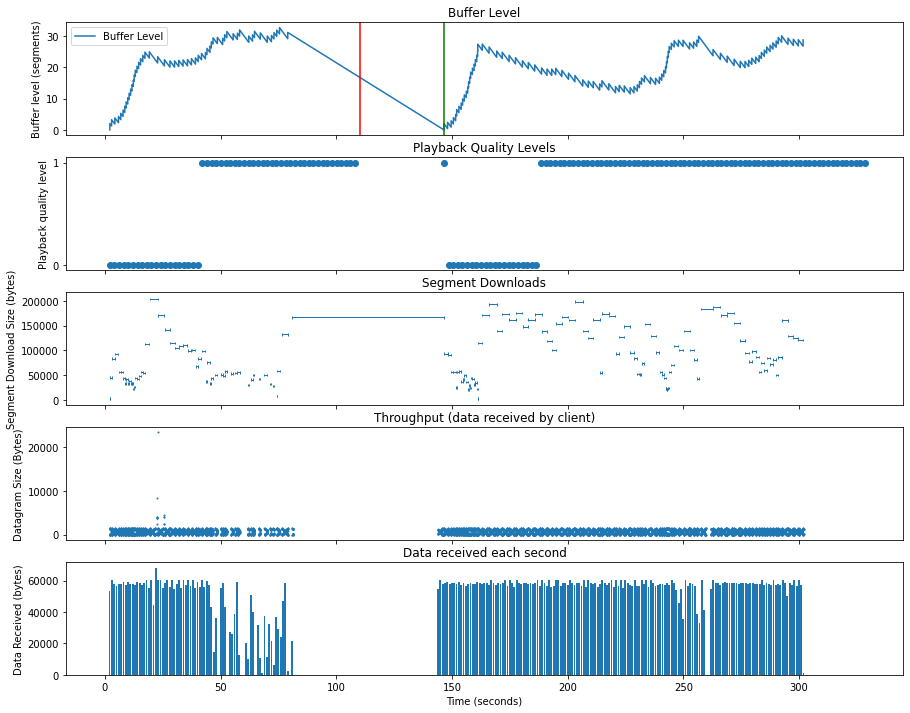

In [32]:
print ("Full timeline for QUIC 500Kbps")
graphFullTimeline(sampleQuicDirSlow)

Full timeline for QUIC 500Kbps


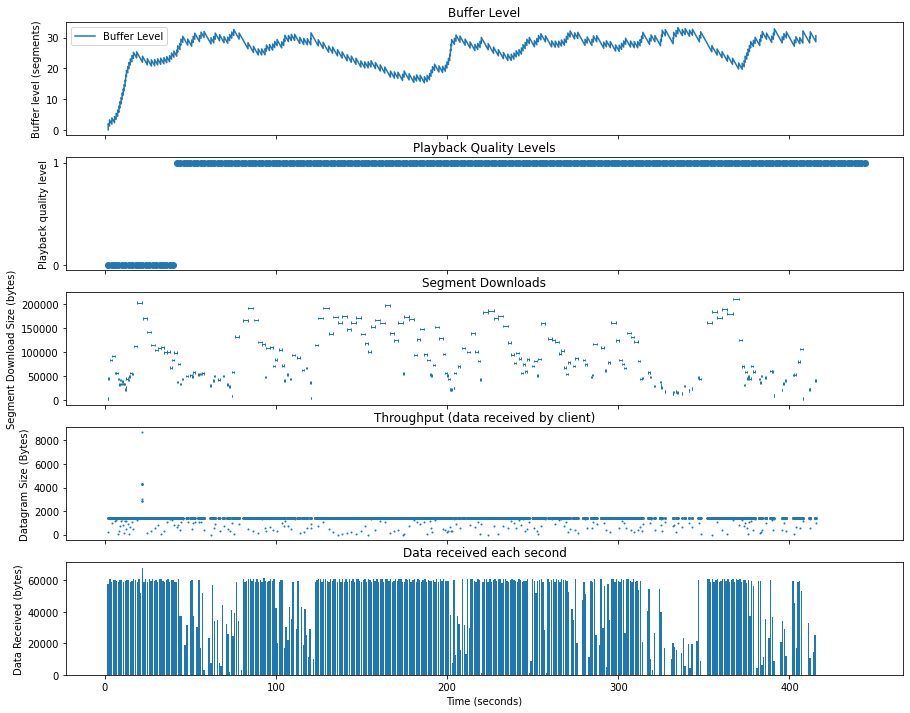

In [34]:
print ("Full timeline for QUIC 500Kbps")
graphFullTimeline(sampleTcpDirSlow)

Full timeline for QUIC 2Mbps
Malformed buffer underflow log. Likely that QUIC failed near time 184.045


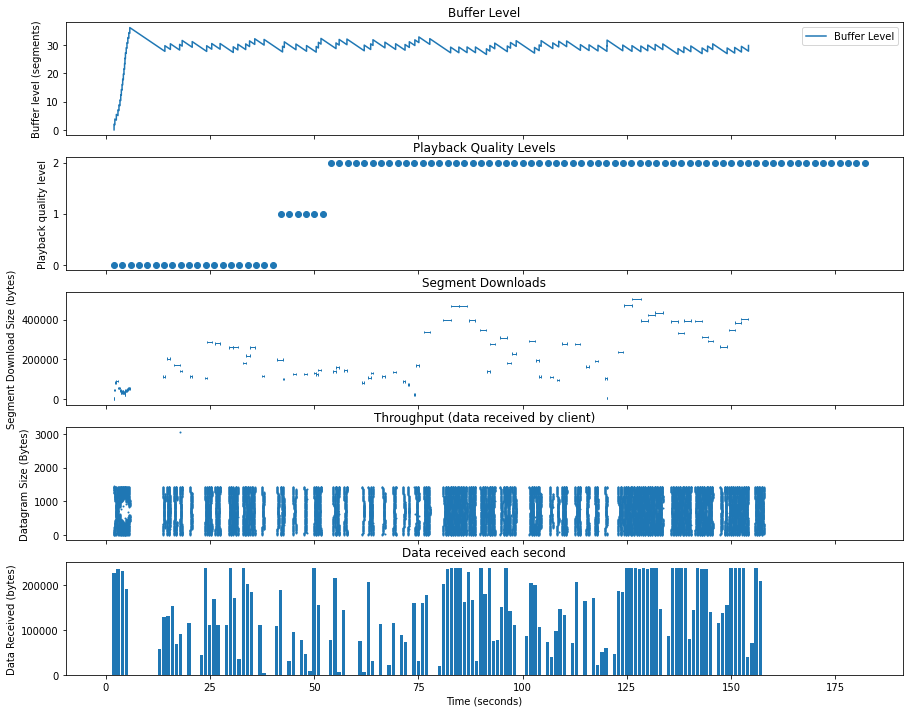

In [35]:
print ("Full timeline for QUIC 2Mbps")
graphFullTimeline(sampleQuicDir)